# Walmart Trip Type Classification - Data Wrangling
### Capstone Project - 1
### By: * Rajesh Dharmarajan *
******************
_This is my first capstone project for Springboard Career Track. This is a classification problem with Data from Walmart to predict the Trip Type. This is orginally from a Kaggle competition_

** Overview **


Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different trip types. 

Whether they're on a last minute run for new puppy supplies or leisurely making their way through a weekly grocery list, classifying trip types enables Walmart to create the best shopping experience for every customer.

Currently, Walmart's trip types are created from a combination of existing customer insights ("art") and purchase history data ("science"). 

The challenge here is to classify customer trips using only a transactional dataset of the items they've purchased.

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification


In [2]:
import pandas as pd
import tkinter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)

** Read the file **

In [3]:
df_walmart_raw = pd.read_csv('wm_train.csv')

**Data fields**

* TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
* VisitNumber - an id corresponding to a single trip by a single customer
* Weekday - the weekday of the trip
* Upc - the UPC number of the product purchased
* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
* DepartmentDescription - a high-level description of the item's department
* FinelineNumber - a more refined category for each of the products, created by Walmart

In [4]:
df_walmart_raw.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [5]:
df_walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB




Lets look at the data
****

In [6]:
unique_trips = len(df_walmart_raw.VisitNumber.unique())# number of unique trips - 95,674

In [7]:
unique_UPC = len(df_walmart_raw.Upc.unique())# number of unique UPC - 97,715

In [8]:
unique_FilelineNumber = len(df_walmart_raw.FinelineNumber.unique()) # number of unique FinelineNumber - 5,196

In [9]:
unique_TripTypes = len(df_walmart_raw.TripType.unique())#38 different types of Trips

In [10]:
unique_departments = len(df_walmart_raw.DepartmentDescription.unique())#69 different types of departments

There are rows where both the UPC and Depeartment Description does not contain any value. Remove these rows from the 
data since, without knowning what the customer bought or returned, the trip cannot be classified. So, discard these rows

In [11]:
df_walmart_1st_cleanse = df_walmart_raw[(df_walmart_raw.Upc.notnull())|(df_walmart_raw.DepartmentDescription.notnull())]

In [12]:
no_of_obs = len(df_walmart_1st_cleanse) # 645,693 observations after dropping the ones with null UPCs

In [13]:
unique_nonnull_trips = len(df_walmart_1st_cleanse.VisitNumber.unique())# number of unique trips - 95,674

In [14]:
df_walmart_1st_cleanse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645693 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 645693 non-null int64
VisitNumber              645693 non-null int64
Weekday                  645693 non-null object
Upc                      642925 non-null float64
ScanCount                645693 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.4+ MB


****
## UPC that occur just once
there are a large number of UPCs that occur only once, analyze this data so see if there is any pattern

In [15]:
#get all the UPCs that show up just one and store it as a series
#the UPC will be the key(axes) and the number of times it occurs
#i.e. 1 will be the value
count_series = df_walmart_1st_cleanse.Upc.value_counts()

In [16]:
count_series = count_series[count_series.values<2]

In [17]:
#get the UPCs into a list
upc_once_occurs_list = count_series.axes[0]

In [18]:
#get the list of VisitNumbers that have the UPCs that occcur just once
upc_once_visits = df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(upc_once_occurs_list)].VisitNumber.unique()

In [19]:
len(upc_once_occurs_list)
# there are 37,080 UPCs that occur only once, total unique UPCs - 97,715

37080

In [20]:
len(upc_once_visits)
#22,415 visits contain UPCs that occur only once, total number of visits in this data 95,674

22415

In [21]:
#get the dataframe with all the Visits that have UPCs that occur once
df_wm_upc_once = df_walmart_1st_cleanse[df_walmart_1st_cleanse.VisitNumber.isin(upc_once_visits)]

In [22]:
df_wm_upc_once.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0


#### From the above data, it looks like UPCs occuring once does not have much effect on the Trip Type classification
****

## Lets look at the number of items for each VisitNumber 



In [23]:
df_visits = pd.DataFrame(df_walmart_1st_cleanse.VisitNumber.value_counts().axes[0]) 

In [24]:
df_visits.columns = ['VisitNumber']

In [25]:
df_visits['no_of_items']=df_walmart_1st_cleanse.VisitNumber.value_counts().values
#df_walmart_1st_cleanse.VisitNumber.value_counts().values

In [26]:
df_visits['TripType']=df_walmart_1st_cleanse[df_walmart_1st_cleanse.VisitNumber.isin(df_visits.VisitNumber)].TripType
#df_visits[0]

In [27]:
df_visits['Day']=df_walmart_1st_cleanse[df_walmart_1st_cleanse.VisitNumber.isin(df_visits.VisitNumber)].Weekday

In [28]:
df_visits.head()

,VisitNumber,no_of_items,TripType,Day
0,72439,209,999.0,Friday
1,88011,151,30.0,Friday
2,9181,113,30.0,Friday
3,60971,112,26.0,Friday
4,65792,109,26.0,Friday


In [29]:
len(df_visits)

95516

** Check if there is a correlation between 'number of items' and the Trip Type **

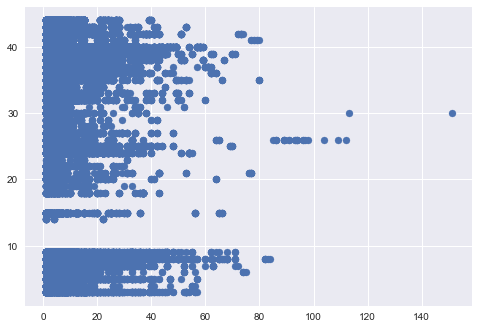

In [30]:
plt.scatter(df_visits[df_visits.TripType<999].no_of_items,df_visits[df_visits.TripType<999].TripType)

_ there is no correlation _

****
### Lets create a vector based on items 'department description'  and the 'scanned counts' in each visit

In [31]:
dept_list = df_walmart_1st_cleanse.DepartmentDescription.unique()

In [32]:
len(dept_list)

68

In [33]:
dept_list.sort()

In [34]:
dept_list

array(['1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
       'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
       'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES',
       'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD',
       'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS',
       'HOME DECOR', 'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL',
       'INFANT CONSUMABLE HARDLINES', 'JEWELRY AND SUNGLASSES',
       'LADIES SOCKS', 'LADIESWEAR', 'LARGE HOUSEHOLD GOODS',
       'LAWN AND GARDEN', 'LIQUOR,WINE,BEER', 'MEAT - FRESH & FROZEN',
       'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR', 'OFFICE SUPPLIES',
       'OPTICAL - FRAMES', 'OPTICAL 

In [35]:
grouped = df_walmart_1st_cleanse.groupby([df_walmart_1st_cleanse.VisitNumber])

In [36]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse.ScanCount.isnull()].head(5)#check there are no not null Scan Counts

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber


In [37]:
'''
this function builds a vector of department descriptions for each visit
*** input ***  
dept_dict - dictionary of department descriptions - all set to zero
dept_series - a Series of all the department description in the order
scan_series - a Series of all the scan count ordered in the same way as department description
*** output ***
numpy array of the scan counts, i.e., total scanned items for a particular department
'''
def buildDeptVector(dept_dict, dept_series, scan_series):
    for i in range(0,len(dept_series)):
        if (dept_series.iloc[i] in dept_dict):
            dept_dict[dept_series.iloc[i]] = dept_dict[dept_series.iloc[i]]+scan_series.iloc[i]
    return list(dept_dict.values())


In [38]:
dept_vect_dict = {}
dept_scan_vect_dict={}

In [39]:
new_df_list=[]
for name,group in grouped:
    dept_scan_vect_dict = dept_scan_vect_dict.fromkeys(dept_list,0)
    ls_dept_scan_vect=[]
    #print('before call:',ls_dept_scan_vect,':')
    #print('dept_vect_dict:',dept_scan_vect_dict,':')
    #print('group.DepartmentDescription:',group.DepartmentDescription,':')
    #print('dept_scan_vect_dict:',dept_scan_vect_dict,':')
    #print('group.ScanCount',group.ScanCount,':')
    ls_dept_scan_vect = buildDeptVector(dept_scan_vect_dict,group.DepartmentDescription,group.ScanCount)
    ls_dept_scan_vect.insert(0,name)
    new_df_list.append(ls_dept_scan_vect)
    #print('after call:',ls_dept_scan_vect,':')

In [40]:
dept_list_col_head = list(dept_list)#.insert(0,name)

In [41]:
dept_list_col_head.insert(0,'VisitNumber')

In [42]:
df_visit_dept_vector = pd.DataFrame.from_records(new_df_list)

In [43]:
df_visit_dept_vector.columns=dept_list_col_head

In [44]:
df_visit_dept_vector.head(10)

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,12,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,17,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
#check to see if we have got 95,516 visits
len(df_visit_dept_vector)

95516

In [46]:
df_visit_dept_vector[df_visit_dept_vector['VisitNumber']==72439]

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
36196,72439,0,0,0,0,37,7,8,0,10,0,0,0,1,0,0,55,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,14,36,29,0,0,0,0,6,0,0,0,20,0,0,0,0,0,0,64,0,10,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0


In [47]:
# concat the two dataframes df_visits and df_visit_dept_vector
df_visits = pd.concat([df_visits.set_index('VisitNumber'),df_visit_dept_vector.set_index('VisitNumber')],axis=1).sort_index()

In [48]:
df_visits.head(5)

,no_of_items,TripType,Day,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1,8.0,Monday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2,37.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,22,999.0,Friday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3,40.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
10,3,31.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
df_visits.loc[8]

no_of_items                       22
TripType                         999
Day                           Friday
1-HR PHOTO                         0
ACCESSORIES                        0
AUTOMOTIVE                         0
BAKERY                             0
BATH AND SHOWER                    0
BEAUTY                             0
BEDDING                            0
BOOKS AND MAGAZINES                0
BOYS WEAR                          0
BRAS & SHAPEWEAR                   0
CAMERAS AND SUPPLIES               0
CANDY, TOBACCO, COOKIES            0
CELEBRATION                        0
COMM BREAD                         0
CONCEPT STORES                     0
COOK AND DINE                      0
DAIRY                              2
DSD GROCERY                        1
ELECTRONICS                        0
FABRICS AND CRAFTS                 0
FINANCIAL SERVICES                 0
FROZEN FOODS                       0
FURNITURE                          0
GIRLS WEAR, 4-6X  AND 7-14         0
G

In [50]:
trip_types=(list(df_walmart_raw.TripType.unique()))

In [51]:
trip_types.sort()

In [52]:
#df_visits.to_csv('visits.csv')

In [53]:
trip_types

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 12,
 14,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 999]

In [54]:
#df_walmart_1st_cleanse.Upc.value_counts().head(5000).sum()
#df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(df_walmart_1st_cleanse.Upc.value_counts().head(50))]

In [62]:
df_temp_visits = df_visits.copy(deep=True)

In [63]:
df_temp_visits.head(5)

,no_of_items,TripType,Day,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1,8.0,Monday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2,37.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,22,999.0,Friday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3,40.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
10,3,31.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
df_temp_visits['TripType'] =df_temp_visits['TripType'].map({3:1,
4:2,
5:3,
6:4,
7:5,
8:6,
9:7,
12:8,
14:9,
15:10,
18:11,
19:12,
20:13,
21:14,
22:15,
23:16,
24:17,
25:18,
26:19,
27:20,
28:21,
29:22,
30:23,
31:24,
32:25,
33:26,
34:27,
35:28,
36:29,
37:30,
38:31,
39:32,
40:33,
41:34,
42:35,
43:36,
44:37,
999:38})

In [72]:
len(df_temp_visits)

95516

In [69]:
from sklearn.model_selection import train_test_split

In [73]:
train_df, test_df = train_test_split(df_temp_visits,test_size=0.2)

In [74]:
train_df.head(5)

,no_of_items,TripType,Day,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENS WEAR,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
88235,10,33.0,Friday,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,1,0,0,0,0,0
183093,4,33.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
84827,1,17.0,Tuesday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
80569,18,32.0,Friday,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,0,5,0,1,0
52522,23,13.0,Friday,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,8,0,0,1,1,0,0,1,0,0,0,0,0,2,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0


In [75]:
from sklearn.linear_model import LogisticRegression

In [79]:
logreg=LogisticRegression(C=1e5,solver='sag')

In [114]:
X=train_df.iloc[:,3:]#use all categories as predictors

In [115]:
Y = train_df.iloc[:,1:2]#trip type to be predicted

In [116]:
X = X.as_matrix().astype(np.float)

In [117]:
Y = Y.as_matrix().astype(np.float)

In [123]:
Y=Y.ravel()

In [124]:
X.shape,Y.shape

((76412, 68), (76412,))

In [143]:
logreg.fit(X,Y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [126]:
np.isfinite(X).all()

True

In [99]:
np.all(np.isfinite(X))

True

In [107]:
X.shape

(76412, 68)

In [108]:
Y.shape

(76412, 1)

In [139]:
if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())          and not np.isfinite(X).all()):
    print('yes')
else:
    print('no')
    

no


In [127]:
X.dtype.char in np.typecodes['AllFloat']

True

In [131]:
not np.isfinite(X.sum())

False

In [136]:
np.isfinite(X).all()

True

In [134]:
np.where(X.values >= np.finfo(np.float64).max)

AttributeError: 'numpy.ndarray' object has no attribute 'values'